# Run Firefly on an example Globular Cluster spectrum

In [1]:
import os
import glob
import numpy as np
import pyfits
import astropy.cosmology as co
import GalaxySpectrumFIREFLY as gs
import StellarPopulationModel as spm
from firefly_dust import get_dust_radec
import time, datetime
from matplotlib import pyplot as plt
%matplotlib notebook

date_stamp = datetime.datetime.today().strftime('%d%b%y')

# setting up directories and file to be tested
gcs_directory = 'example_data/spectra/'
output_directory = '../output/'

if os.path.isdir(output_directory)==False:
    os.mkdir(output_directory) 

# select the M11-library and IMF type for the models to be used
models_used = 'ELODIE'
imf_used = 'cha'


We provide a combined grating spectrum of a globular cluster spectrum from Usher et al. 2015, WAGGS data.

In [2]:
gcs_file = 'NGC7099_2016-10-01.fits'

cosmo = co.Planck13
# select the M11-library and IMF type for the models to be used
models_used = 'ELODIE'
imf_used = 'cha'

# the resolution of the M11-MARCS and M11-ELODIE models are higher than the GC data, 
# they require to be convolved
if models_used == 'MARCS' or models_used == 'ELODIE':
    convolve_models = True

# the resolution of the M11-MILES and M11-STELIB models are lower than the GC data, 
# so no convolution required. FF will convolve the GC data to match the one of
# the models - although it is not recommended to ever downgrade observed data
if models_used == 'MILES' or models_used == 'STELIB':
    convolve_models = False

# setting up the routines for FF, this will rint the content of the file
spec_gcs = gs.GalaxySpectrumFIREFLY(gcs_directory+gcs_file, milky_way_reddening=True)
spec_gcs.openGCsUsher()

Filename: example_data/spectra/NGC7099_2016-10-01.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      16   (1, 9417)    float64   
1                ImageHDU         7   (1, 9417)    float64   


In [3]:
# chosen name for the output file to be unique every time FF is run
outFile = output_directory+gcs_file+'_'+imf_used+'_'+date_stamp

Note that the spectral templates needs to be downgraded and this takes a bit of time.

In [4]:
# FF set-up and ready to run
model_gcs = spm.StellarPopulationModel(spec_gcs, outFile, cosmo, models = 'm11',\
                                           model_libs = [models_used], imfs = [imf_used],\
                                           age_limits = [0,15], Z_limits = [-3.,5.], \
                                           wave_limits = [3350.,9000.], \
                                           suffix="_SPM-"+models_used+".fits", \
                                           downgrade_models = convolve_models, \
                                           data_wave_medium = 'vacuum', \
                                           use_downgraded_models = False, write_results = True)
model_gcs.fit_models_to_data()
print('     > done')

     > done


Let's plot the best Firefly fit against the original spectrum:

<IPython.core.display.Javascript object>


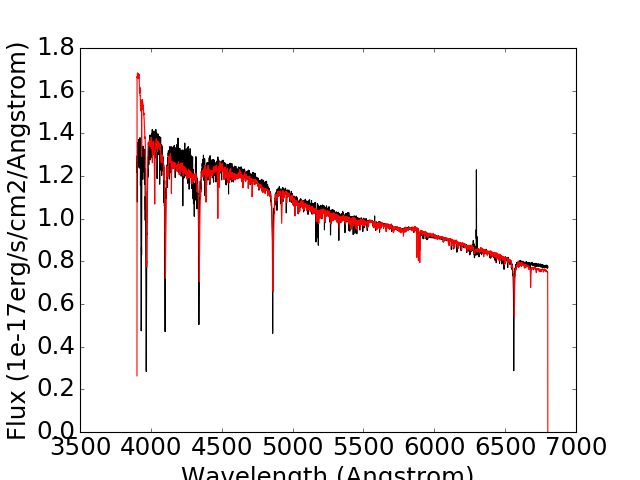

In [5]:
# Load the Firefly FITS file output into the program
hdulist = pyfits.open(glob.glob(outFile+'*')[0])

# Get the relevant data from the file
thefit = 1
wavelength = hdulist[thefit].data['wavelength'] 
original_flux = hdulist[thefit].data['original_data']
bestfit_model = hdulist[thefit].data['firefly_model']
     
# Create the labels of the plots using the units in the header file
xtit = ('Wavelength (%s)' % hdulist[thefit].header['TUNIT1'])
ytit = ('Flux (%s)' % hdulist[thefit].header['TUNIT2'])

# Plot the spectra
plt.plot(wavelength, original_flux, 'k')
plt.plot(wavelength, bestfit_model, 'r')

# Add labels and tick marks
fn = 22
plt.xlabel(xtit, fontsize=fn) ; plt.ylabel(ytit, fontsize=fn)
plt.tick_params(axis='both', which='major', labelsize=fn)
plt.show()